# Cross-Domain ASR (Kaggle P100): Whisper Small.EN — Train on LibriSpeech → Test & Adapt on Local Common Voice v24 en-AU + HPO-lite

This notebook uses **two domains**:

1) **Source training** on **LibriSpeech** (HF dataset `librispeech_asr`, clean speech)  
2) **Target evaluation** on your **local Common Voice v24 en-AU**  
3) **Domain adaptation**: fine-tune on a small local CV train subset  
4) **HPO-lite**: a small sweep to minimize **WER & CER**

Optimized for Kaggle **GPU P100** and ~**19.5GB** output with checkpoint pruning.


In [1]:
# 0) Install deps (Kaggle) — pinned to avoid dependency conflicts
# NOTE: We pin transformers<5 to stay compatible with Kaggle preinstalls (sentence-transformers, etc.)
# and we remove peft because some Kaggle images ship mismatched peft/transformers versions.
!pip -q uninstall -y peft || true

!pip -q install \
  "transformers==4.44.2" \
  "accelerate==0.34.2" \
  "datasets==2.20.0" \
  "jiwer==3.0.4" \
  "soundfile==0.12.1"

import os, re, random, json, math, shutil, glob
import numpy as np
import pandas as pd
import torch
import torchaudio
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Any, Dict, List, Optional
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)
from jiwer import wer as jiwer_wer, cer as jiwer_cer

print("torch:", torch.__version__)
print("transformers:", __import__("transformers").__version__)
print("cuda:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 108.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 99.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.7/146.7 kB 10.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0

2026-02-09 17:14:21.742206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770657261.900723      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770657261.945776      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770657262.332095      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770657262.332138      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770657262.332141      55 computation_placer.cc:177] computation placer alr

torch: 2.8.0+cu126
transformers: 4.44.2
cuda: True
gpu: Tesla P100-PCIE-16GB


In [2]:
# 1) Reproducibility + output
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

OUTPUT_DIR = "/kaggle/working/whisper_ls_to_cv_local_hpo"
os.makedirs(OUTPUT_DIR, exist_ok=True)

MODEL_NAME = "openai/whisper-small.en"


## 2) Locate local Common Voice dataset (auto-detection)


In [3]:
def find_first(patterns, roots=("/kaggle/input", "/kaggle/working", "/kaggle")):
    for root in roots:
        for pat in patterns:
            hits = glob.glob(os.path.join(root, "**", pat), recursive=True)
            if hits:
                return hits[0]
    return None

split_csv = find_first(["commonvoice-v24_en-AU-split.csv", "*split*.csv"])
main_csv  = find_first(["commonvoice-v24_en-AU.csv", "*en-AU*.csv"])

print("Found split CSV:", split_csv)
print("Found main  CSV:", main_csv)
if main_csv is None and split_csv is None:
    raise FileNotFoundError("Could not find your local Common Voice CSVs.")

base_dir = os.path.dirname(split_csv if split_csv else main_csv)
audio_dir_candidates = [os.path.join(base_dir, "audio_files"), os.path.join(base_dir, "clips"), os.path.join(base_dir, "audio")]
audio_dir = next((d for d in audio_dir_candidates if os.path.isdir(d)), None)
print("Base dir:", base_dir)
print("Audio dir:", audio_dir)
if audio_dir is None:
    raise FileNotFoundError("Could not find audio directory (audio_files/clips/audio).")


Found split CSV: /kaggle/input/mozilla-commonvoice/commonvoice-v24_en-AU/commonvoice-v24_en-AU-split.csv
Found main  CSV: /kaggle/input/mozilla-commonvoice/commonvoice-v24_en-AU/commonvoice-v24_en-AU.csv
Base dir: /kaggle/input/mozilla-commonvoice/commonvoice-v24_en-AU
Audio dir: /kaggle/input/mozilla-commonvoice/commonvoice-v24_en-AU/audio_files


In [5]:
# 3) Load CSVs  ✅ (Corrected: handles BOTH long-split and wide-split CSV formats)

def read_csv(path):
    # robust CSV reading (handles different delimiters)
    try:
        return pd.read_csv(path)
    except Exception:
        return pd.read_csv(path, sep=";")

df_main  = read_csv(main_csv) if main_csv else None
df_split = read_csv(split_csv) if split_csv else None

print("main columns:", list(df_main.columns)[:30] if df_main is not None else None)
print("split columns:", list(df_split.columns)[:30] if df_split is not None else None)

# Find transcript column
TEXT_COL_CANDIDATES = ["sentence", "text", "transcript", "normalized_text", "utterance"]
def pick_col(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

# Find audio filename/path column
AUDIO_COL_CANDIDATES = ["path", "audio_path", "filename", "file", "clip", "audio"]
def pick_audio_col(cols):
    for c in AUDIO_COL_CANDIDATES:
        if c in cols:
            return c
    return None

def normalize_split_value(x: str) -> str:
    x = str(x).strip().lower()
    if x in ["train", "tr"]:
        return "train"
    if x in ["valid", "val", "validation", "dev", "devel"]:
        return "val"
    if x in ["test", "te"]:
        return "test"
    return x

# -------------------------
# Determine which dataframe to use for splits
# -------------------------
audio_col = None  # we may set it inside wide-split parsing

if df_split is not None:
    df = df_split.copy()

    # Try LONG format split column (values train/val/test in a column)
    split_col = pick_col(df.columns, ["split", "set", "subset", "partition"])
    if split_col is None:
        # infer from column values
        for c in df.columns:
            vals = set(str(v).lower() for v in df[c].dropna().unique()[:50])
            if any(v in vals for v in ["train", "validation", "valid", "dev", "test", "val"]):
                split_col = c
                break

    # If still none -> try WIDE format where columns are train/val/test and cells contain filenames
    if split_col is None:
        wide_split_cols = []
        for c in df.columns:
            if normalize_split_value(c) in ["train", "val", "test"]:
                wide_split_cols.append(c)

        if len(wide_split_cols) > 0:
            print("Detected WIDE split CSV format. Split columns:", wide_split_cols)

            parts = []
            for c in wide_split_cols:
                tmp = df[[c]].dropna().copy()
                tmp = tmp.rename(columns={c: "path"})  # standard filename column
                tmp["split"] = normalize_split_value(c)
                parts.append(tmp)

            df = pd.concat(parts, ignore_index=True)
            split_col = "split"
            audio_col = "path"  # now our audio column is 'path'

        else:
            # No usable split info -> fall back to main CSV (random split later)
            print("WARNING: Split CSV found but no split column detected. Falling back to main CSV.")
            df = df_main.copy()
            split_col = None

else:
    df = df_main.copy()
    split_col = pick_col(df.columns, ["split", "set", "subset", "partition"])

# -------------------------
# Transcript + audio columns
# -------------------------
text_col = pick_col(df.columns, TEXT_COL_CANDIDATES) or (
    pick_col(df_main.columns, TEXT_COL_CANDIDATES) if df_main is not None else None
)
if text_col is None:
    raise ValueError("Could not find transcript column. Try renaming it to 'sentence' or 'text'.")

# if audio_col not already fixed (wide split case), detect it normally
if audio_col is None:
    audio_col = pick_audio_col(df.columns) or (
        pick_audio_col(df_main.columns) if df_main is not None else None
    )
if audio_col is None:
    raise ValueError("Could not find audio path/filename column. Try 'path' or 'filename'.")

print("Using text column:", text_col)
print("Using audio column:", audio_col)
print("Using split column:", split_col)

# Map split values if split column exists
if split_col is not None and split_col in df.columns:
    df[split_col] = df[split_col].apply(normalize_split_value)

# If df_split lacks transcript, merge transcript from main by a key (audio_col)
if df_split is not None and df_main is not None and text_col not in df_split.columns:
    key = audio_col
    if key in df_main.columns and key in df.columns:
        df = df.merge(df_main[[key, text_col]], on=key, how="left")

# -------------------------
# Build absolute audio paths
# -------------------------
def to_abs_audio_path(x):
    if pd.isna(x):
        return None
    x = str(x)
    # if already absolute
    if os.path.isabs(x) and os.path.exists(x):
        return x
    # try joining base_dir
    p1 = os.path.join(base_dir, x)
    if os.path.exists(p1):
        return p1
    # assume filename in audio_dir
    p2 = os.path.join(audio_dir, os.path.basename(x))
    if os.path.exists(p2):
        return p2
    # handle nested relative like "clips/xxx.mp3" or "audio_files/xxx"
    p3 = os.path.join(base_dir, os.path.normpath(x))
    if os.path.exists(p3):
        return p3
    return p2  # last resort

df["audio_path"] = df[audio_col].apply(to_abs_audio_path)
df["transcript"] = df[text_col].astype(str)

# Drop missing audio files
df = df[df["audio_path"].apply(lambda p: isinstance(p, str) and os.path.exists(p))].reset_index(drop=True)

print("Rows with existing audio:", len(df))
df.head()

main columns: ['Unnamed: 0', 'client_id', 'path', 'sentence_id', 'sentence', 'sentence_domain', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment', 'duration_ms']
split columns: ['Unnamed: 0', 'client_id', 'path', 'sentence_id', 'sentence', 'sentence_domain', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment', 'duration_ms']
Using text column: sentence
Using audio column: path
Using split column: None
Rows with existing audio: 55673


,Unnamed: 0,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment,duration_ms,audio_path,transcript
0,182,0621ad6390e651ff1e39b23f74e8d624bd8ba0957d6a19...,common_voice_en_30513358.mp3,1f08423cd2153df43fb7c18ddd24edfea7be733046c26d...,Princess Vilas herself also contributed person...,NaN,4,0,teens,male_masculine,Australian English,NaN,en,NaN,7.387500,/kaggle/input/mozilla-commonvoice/commonvoice-...,Princess Vilas herself also contributed person...
1,725,18bea6bb076cd9638518d93b4af353c3c329d059789e11...,common_voice_en_43618790.mp3,fe3f016c86bea44ab149bc2537de58f16051d8274099a7...,He has also served in the Chamber of Deputies.,NaN,2,0,NaN,NaN,Australian English,NaN,en,NaN,6.307500,/kaggle/input/mozilla-commonvoice/commonvoice-...,He has also served in the Chamber of Deputies.
2,885,1db7f61c407a3cdce51e21ae1871ef9ae3ed74d79415ba...,common_voice_en_21099981.mp3,48e620d96dda152eeec48e28f7b0dde29625591bdc44cd...,Most of his subjects were found in Devon and C...,NaN,2,0,thirties,male_masculine,Australian English,NaN,en,NaN,7.949625,/kaggle/input/mozilla-commonvoice/commonvoice-...,Most of his subjects were found in Devon and C...
3,984,2144a6feb6a906b220cbba00f37b56084bd2d60cce773e...,common_voice_en_39588772.mp3,e3d037f2c263d604b0bb1ef837b1fc7ee7f80d5336031c...,Shots rang out as they fled towards the Austri...,NaN,2,0,NaN,NaN,Australian English,NaN,en,NaN,5.515500,/kaggle/input/mozilla-commonvoice/commonvoice-...,Shots rang out as they fled towards the Austri...
4,1021,22b4048e01f359c779cf9a692f5da7512bfd7ef8c9fff2...,common_voice_en_37211578.mp3,cdfb0356e09201212c123e83ab27e43c48a62b6ce8520d...,The system is based on electromagnetic induction.,NaN,2,0,NaN,NaN,Australian English,NaN,en,NaN,4.055656,/kaggle/input/mozilla-commonvoice/commonvoice-...,The system is based on electromagnetic induction.


In [6]:
# 4) Filter local CV and create subsets for target evaluation/adaptation
MIN_AUDIO_SEC = 0.2
MAX_AUDIO_SEC = 15.0

def get_duration_sec(path: str):
    try:
        info = torchaudio.info(path)
        return info.num_frames / info.sample_rate
    except Exception:
        return None

def normalize_for_metrics(s: str) -> str:
    s = s.lower()
    s = re.sub(r"\[[^\]]*\]", " ", s)
    s = re.sub(r"[^a-z' ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["duration"] = df["audio_path"].apply(get_duration_sec)
df = df.dropna(subset=["duration"]).reset_index(drop=True)
df = df[(df["duration"] >= MIN_AUDIO_SEC) & (df["duration"] <= MAX_AUDIO_SEC)].reset_index(drop=True)

df["transcript"] = df["transcript"].astype(str).str.strip()
df = df[df["transcript"].str.len() >= 2].reset_index(drop=True)
df["text_norm"] = df["transcript"].apply(normalize_for_metrics)

if split_col is not None and split_col in df.columns and df[split_col].isin(["train","val","test"]).any():
    cv_train_df = df[df[split_col] == "train"].copy()
    cv_val_df   = df[df[split_col] == "val"].copy()
    cv_test_df  = df[df[split_col] == "test"].copy()
else:
    df_shuf = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)
    n = len(df_shuf)
    n_train = int(0.8*n)
    n_val = int(0.1*n)
    cv_train_df = df_shuf.iloc[:n_train].copy()
    cv_val_df   = df_shuf.iloc[n_train:n_train+n_val].copy()
    cv_test_df  = df_shuf.iloc[n_train+n_val:].copy()

# Subsample sizes (increase for better results)
N_CV_TEST = min(800, len(cv_test_df))
N_CV_FT_TRAIN = min(1500, len(cv_train_df))
N_CV_FT_VAL = min(300, len(cv_val_df))

cv_test_df = cv_test_df.sample(n=N_CV_TEST, random_state=SEED) if len(cv_test_df) > N_CV_TEST else cv_test_df
cv_ft_train_df = cv_train_df.sample(n=N_CV_FT_TRAIN, random_state=SEED) if len(cv_train_df) > N_CV_FT_TRAIN else cv_train_df
cv_ft_val_df = cv_val_df.sample(n=N_CV_FT_VAL, random_state=SEED) if len(cv_val_df) > N_CV_FT_VAL else cv_ft_val_df

print("Local CV subsets:", len(cv_ft_train_df), len(cv_ft_val_df), len(cv_test_df))


/tmp/ipykernel_55/3868897756.py:7: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  info = torchaudio.info(path)
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:20: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s = torchaudio.io.Str

Local CV subsets: 1500 300 800


## 5) EDA (target test subset)



--- Local CV TEST (target) ---
N: 800
Duration mean: 5.063 p95: 8.09
Text len mean: 55.36 p95: 91.0
Top 10 words: [('the', 556), ('a', 190), ('of', 189), ('to', 177), ('and', 162), ('is', 159), ('in', 157), ('was', 104), ('he', 85), ('it', 82)]


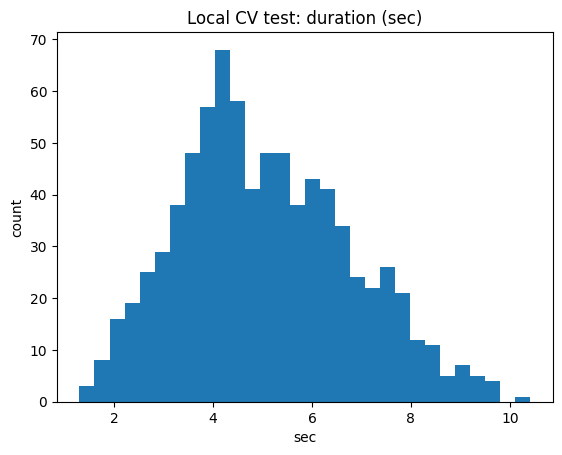

In [7]:
from collections import Counter

def eda_basic(df_, name):
    print(f"\n--- {name} ---")
    print("N:", len(df_))
    print("Duration mean:", round(df_['duration'].mean(), 3), "p95:", round(df_['duration'].quantile(0.95), 3))
    tl = df_["text_norm"].str.len()
    print("Text len mean:", round(tl.mean(), 2), "p95:", round(tl.quantile(0.95), 2))
    words = Counter(" ".join(df_["text_norm"].tolist()).split())
    print("Top 10 words:", words.most_common(10))

eda_basic(cv_test_df, "Local CV TEST (target)")
plt.figure()
plt.hist(cv_test_df["duration"], bins=30)
plt.title("Local CV test: duration (sec)")
plt.xlabel("sec"); plt.ylabel("count")
plt.show()


## 6) Audio preprocessing + torch datasets


In [8]:
_resamplers = {}

def trim_silence(wave: torch.Tensor, thr: float = 0.01):
    if wave.numel() < 10:
        return wave
    mask = wave.abs() > thr
    if mask.any():
        i0 = int(mask.argmax())
        i1 = int(len(mask) - mask.flip(0).argmax())
        return wave[i0:i1]
    return wave

def load_audio_16k_mono(path: str, do_trim: bool = False):
    wav, sr = torchaudio.load(path)
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    wav = wav.squeeze(0)
    if sr != 16000:
        key = (sr, 16000)
        if key not in _resamplers:
            _resamplers[key] = torchaudio.transforms.Resample(sr, 16000)
        wav = _resamplers[key](wav)
    if do_trim:
        wav = trim_silence(wav)
    return wav

class ASRDataset(torch.utils.data.Dataset):
    def __init__(self, df_: pd.DataFrame):
        self.df = df_.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        return {"audio_path": r.audio_path, "text": r.transcript, "text_norm": r.text_norm}

cv_test_ds = ASRDataset(cv_test_df)
cv_ft_train_ds = ASRDataset(cv_ft_train_df)
cv_ft_val_ds = ASRDataset(cv_ft_val_df)

len(cv_test_ds), len(cv_ft_train_ds), len(cv_ft_val_ds)


(800, 1500, 300)

## 7) Load LibriSpeech (streaming) and sample subsets


In [10]:
# 7) Load LibriSpeech from LOCAL Kaggle folder (no HF streaming, no load_dataset)

import os, random
from pathlib import Path
import pandas as pd
import torchaudio

# If not already defined above
# MIN_AUDIO_SEC = 0.2
# def get_duration_sec(path: str):
#     try:
#         info = torchaudio.info(path)
#         return info.num_frames / info.sample_rate
#     except Exception:
#         return None
#
# def normalize_for_metrics(s: str) -> str:
#     s = s.lower()
#     s = re.sub(r"\[[^\]]*\]", " ", s)
#     s = re.sub(r"[^a-z' ]+", " ", s)
#     s = re.sub(r"\s+", " ", s).strip()
#     return s

# --- auto-detect LibriSpeech root inside /kaggle/input ---
def find_librispeech_root():
    candidates = []
    for base in ["/kaggle/input", "/kaggle/working"]:
        base_p = Path(base)
        if not base_p.exists():
            continue
        for p in base_p.rglob("*"):
            if p.is_dir() and (
                (p / "dev-clean").exists()
                or any((p / x).exists() for x in ["train-clean-100", "train-clean-360", "train-other-500"])
            ):
                # likely root if it contains LibriSpeech split dirs
                if (p / "dev-clean").exists() and (
                    (p / "train-clean-360").exists() or (p / "train-clean-100").exists()
                ):
                    candidates.append(p)
    # pick the shortest path (closest to root)
    candidates = sorted(candidates, key=lambda x: len(str(x)))
    return str(candidates[0]) if candidates else None

LIBRISPEECH_ROOT = find_librispeech_root()
print("Detected LIBRISPEECH_ROOT:", LIBRISPEECH_ROOT)
if LIBRISPEECH_ROOT is None:
    raise FileNotFoundError(
        "Could not auto-detect LibriSpeech root. "
        "Set LIBRISPEECH_ROOT manually to the folder that contains dev-clean/train-clean-360/test-clean."
    )

# Choose which splits to use (based on what you said you have)
LS_TRAIN_DIRS = ["train-clean-360"]  # you have this
LS_VAL_DIRS   = ["dev-clean"]        # you have this
LS_TEST_DIRS  = ["test-clean"]       # you have this

# Subset sizes (keep modest for Kaggle P100 speed; increase gradually)
N_LS_TRAIN = 8000
N_LS_VAL   = 500
N_LS_TEST  = 500

MAX_AUDIO_SEC_LS = 15.0  # filter long clips
MIN_AUDIO_SEC_LS = MIN_AUDIO_SEC

def iter_librispeech_rows(split_dir: Path):
    """
    LibriSpeech structure:
      split_dir/**/**/**.trans.txt
    Each .trans.txt line:
      <utt_id> <transcription...>
    Audio path:
      same folder / <utt_id>.flac
    """
    trans_files = list(split_dir.rglob("*.trans.txt"))
    random.shuffle(trans_files)
    for tf in trans_files:
        try:
            with open(tf, "r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    parts = line.split()
                    utt_id = parts[0]
                    text = " ".join(parts[1:])
                    audio_path = tf.parent / f"{utt_id}.flac"
                    if audio_path.exists():
                        yield str(audio_path), text
        except Exception:
            continue

def build_librispeech_subset(split_names, n_max):
    rows = []
    for name in split_names:
        split_dir = Path(LIBRISPEECH_ROOT) / name
        if not split_dir.exists():
            print(f"WARNING: Missing split folder: {split_dir}")
            continue

        for audio_path, text in iter_librispeech_rows(split_dir):
            if len(text.strip()) < 2:
                continue
            dur = get_duration_sec(audio_path)
            if dur is None:
                continue
            if dur < MIN_AUDIO_SEC_LS or dur > MAX_AUDIO_SEC_LS:
                continue

            rows.append({
                "audio_path": audio_path,
                "transcript": text,
                "text_norm": normalize_for_metrics(text),
                "duration": dur
            })

            if len(rows) >= n_max:
                return pd.DataFrame(rows)
    return pd.DataFrame(rows)

ls_train_df = build_librispeech_subset(LS_TRAIN_DIRS, N_LS_TRAIN)
ls_val_df   = build_librispeech_subset(LS_VAL_DIRS,   N_LS_VAL)
ls_test_df  = build_librispeech_subset(LS_TEST_DIRS,  N_LS_TEST)

print("LibriSpeech subsets:", ls_train_df.shape, ls_val_df.shape, ls_test_df.shape)
display(ls_train_df.head())

# Wrap into your existing torch Dataset class
ls_train_ds = ASRDataset(ls_train_df)
ls_val_ds   = ASRDataset(ls_val_df)
ls_test_ds  = ASRDataset(ls_test_df)

Detected LIBRISPEECH_ROOT: /kaggle/input/librispeech-asr-corpus


/tmp/ipykernel_55/3868897756.py:7: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  info = torchaudio.info(path)
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:20: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s = torchaudio.io.Str

LibriSpeech subsets: (8000, 4) (500, 4) (500, 4)


,audio_path,transcript,text_norm,duration
0,/kaggle/input/librispeech-asr-corpus/train-cle...,THE READER PERHAPS HAS NOT FORGOTTEN WHAT WAS ...,the reader perhaps has not forgotten what was ...,7.870000
1,/kaggle/input/librispeech-asr-corpus/train-cle...,AND THEIR NATURE IS ALWAYS SIMILAR WE ARE ALL ...,and their nature is always similar we are all ...,14.100000
2,/kaggle/input/librispeech-asr-corpus/train-cle...,MAY ALWAYS ATTAIN TO THE DEGREE OF PROFICIENCY...,may always attain to the degree of proficiency...,13.915000
3,/kaggle/input/librispeech-asr-corpus/train-cle...,HE COMMUNICATES WITH HIS FELLOWS THROUGH THE M...,he communicates with his fellows through the m...,11.530000
4,/kaggle/input/librispeech-asr-corpus/train-cle...,THE APTITUDES OF ALL THE INDIVIDUALS THOUGH VE...,the aptitudes of all the individuals though ve...,8.599937


## 8) Whisper model + collator + metrics


In [11]:
processor = WhisperProcessor.from_pretrained(MODEL_NAME)
model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME)

model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="en", task="transcribe")
model.config.use_cache = False
model.gradient_checkpointing_enable()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

@dataclass
class DataCollatorWhisper:
    processor: WhisperProcessor
    do_trim: bool = False
    max_label_length: int = 256

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        audio_arrays, texts = [], []
        for f in features:
            wav = load_audio_16k_mono(f["audio_path"], do_trim=self.do_trim)
            audio_arrays.append(wav.numpy())
            texts.append(f["text"])

        inputs = self.processor.feature_extractor(audio_arrays, sampling_rate=16000, return_tensors="pt")
        input_features = inputs["input_features"]

        labels = self.processor.tokenizer(
            texts, padding=True, truncation=True, max_length=self.max_label_length, return_tensors="pt"
        )["input_ids"]
        labels[labels == self.processor.tokenizer.pad_token_id] = -100

        bos = self.processor.tokenizer.bos_token_id
        if bos is not None and (labels[:, 0] == bos).all():
            labels = labels[:, 1:]

        return {"input_features": input_features, "labels": labels}

data_collator_default = DataCollatorWhisper(processor=processor, do_trim=False, max_label_length=256)

def compute_metrics(pred):
    pred_ids = pred.predictions
    if isinstance(pred_ids, tuple):
        pred_ids = pred_ids[0]
    label_ids = pred.label_ids.copy()
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    pred_norm = [normalize_for_metrics(s) for s in pred_str]
    lab_norm  = [normalize_for_metrics(s) for s in label_str]

    return {"wer_norm": jiwer_wer(lab_norm, pred_norm), "cer_norm": jiwer_cer(lab_norm, pred_norm)}

print("Model ready.")


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

Model ready.


## 9) Args + checkpoint pruning


In [14]:
def prune_checkpoints(folder: str, keep_last_n: int = 1):
    if not os.path.isdir(folder):
        return
    cks = [d for d in os.listdir(folder) if d.startswith("checkpoint-")]
    if len(cks) <= keep_last_n:
        return
    cks = sorted(cks, key=lambda x: int(x.split("-")[-1]))
    for ck in cks[:-keep_last_n]:
        shutil.rmtree(os.path.join(folder, ck), ignore_errors=True)

def make_args(run_name: str, lr: float, epochs: int, batch: int, accum: int, eval_steps: int = 200, max_steps: int = -1):
    out = os.path.join(OUTPUT_DIR, run_name)
    os.makedirs(out, exist_ok=True)
    return Seq2SeqTrainingArguments(
        output_dir=out,
        per_device_train_batch_size=batch,
        per_device_eval_batch_size=batch,
        gradient_accumulation_steps=accum,
        learning_rate=lr,
        warmup_steps=100,
        num_train_epochs=epochs,
        fp16=True,
        gradient_checkpointing=True,
        evaluation_strategy="steps",
        save_strategy="steps",
        eval_steps=eval_steps,
        save_steps=eval_steps,
        logging_steps=50,
        save_total_limit=2,
        predict_with_generate=True,
        generation_max_length=225,
        load_best_model_at_end=True,
        metric_for_best_model="wer_norm",
        greater_is_better=False,
        report_to="none",
        max_steps=max_steps,
        remove_unused_columns=False,
    )


## 10) Stage 1 — Train on LibriSpeech


In [15]:
S1_RUN = "stage1_librispeech"
S1_LR = 1e-5
S1_EPOCHS = 2
S1_BATCH = 4
S1_ACCUM = 4

s1_args = make_args(S1_RUN, lr=S1_LR, epochs=S1_EPOCHS, batch=S1_BATCH, accum=S1_ACCUM, eval_steps=200)

s1_trainer = Seq2SeqTrainer(
    model=model,
    args=s1_args,
    train_dataset=ls_train_ds,
    eval_dataset=ls_val_ds,
    data_collator=data_collator_default,
    tokenizer=processor.feature_extractor,
    compute_metrics=compute_metrics,
)

s1_trainer.train()
s1_trainer.save_model(os.path.join(OUTPUT_DIR, S1_RUN, "best_model"))
prune_checkpoints(os.path.join(OUTPUT_DIR, S1_RUN), keep_last_n=1)

s1_val = s1_trainer.evaluate()
print("Stage1 LibriSpeech VAL:", s1_val)
pd.DataFrame([s1_val]).to_csv(os.path.join(OUTPUT_DIR, S1_RUN, "val_metrics.csv"), index=False)


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn

Step,Training Loss,Validation Loss,Wer Norm,Cer Norm
200,0.192300,0.193808,0.040539,0.014716
400,0.144400,0.159531,0.090433,0.065005
600,0.075800,0.147479,0.135873,0.097169
800,0.071500,0.141929,0.113487,0.088742
1000,0.069200,0.139301,0.140216,0.118322


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 357, 366, 438, 532, 685, 705, 796, 930, 1058, 1220, 1267, 1279, 1303, 1343, 1377, 1391, 1635, 1782, 1875, 2162, 2361, 2488, 3467, 4008, 4211, 4600, 4808, 5299, 5855, 6329, 7203, 9609, 9959, 10563, 10786, 11420, 11709, 11907, 13163, 13697, 13700, 14808, 15306, 16410, 16791, 17992, 19203, 19510, 20724, 22305, 22935, 2700

Stage1 LibriSpeech VAL: {'eval_loss': 0.19380831718444824, 'eval_wer_norm': 0.040539035527341574, 'eval_cer_norm': 0.01471615812988333, 'eval_runtime': 180.8963, 'eval_samples_per_second': 2.764, 'eval_steps_per_second': 0.691, 'epoch': 2.0}


## 11) Stage 2 — Zero-shot on local Common Voice test


In [16]:
cv_zero = s1_trainer.evaluate(cv_test_ds)
print("Stage2 CV ZERO-SHOT TEST:", cv_zero)
pd.DataFrame([cv_zero]).to_csv(os.path.join(OUTPUT_DIR, S1_RUN, "cv_zero_shot_test_metrics.csv"), index=False)


Stage2 CV ZERO-SHOT TEST: {'eval_loss': 0.8991472125053406, 'eval_wer_norm': 0.1042708734128511, 'eval_cer_norm': 0.04551817566041996, 'eval_runtime': 229.1898, 'eval_samples_per_second': 3.491, 'eval_steps_per_second': 0.873, 'epoch': 2.0}


## 12) Stage 3 — Fine-tune on local Common Voice


In [17]:
base_model_path = os.path.join(OUTPUT_DIR, S1_RUN, "best_model")
model = WhisperForConditionalGeneration.from_pretrained(base_model_path)
model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="en", task="transcribe")
model.config.use_cache = False
model.gradient_checkpointing_enable()
model.to(device)

S3_RUN = "stage3_cv_finetune"
S3_LR = 5e-6
S3_EPOCHS = 1
S3_BATCH = 4
S3_ACCUM = 4

s3_args = make_args(S3_RUN, lr=S3_LR, epochs=S3_EPOCHS, batch=S3_BATCH, accum=S3_ACCUM, eval_steps=200)

s3_trainer = Seq2SeqTrainer(
    model=model,
    args=s3_args,
    train_dataset=cv_ft_train_ds,
    eval_dataset=cv_ft_val_ds,
    data_collator=data_collator_default,
    tokenizer=processor.feature_extractor,
    compute_metrics=compute_metrics,
)

s3_trainer.train()
s3_trainer.save_model(os.path.join(OUTPUT_DIR, S3_RUN, "best_model"))
prune_checkpoints(os.path.join(OUTPUT_DIR, S3_RUN), keep_last_n=1)

s3_val = s3_trainer.evaluate()
s3_test = s3_trainer.evaluate(cv_test_ds)
print("Stage3 CV VAL:", s3_val)
print("Stage3 CV TEST:", s3_test)

pd.DataFrame([s3_val]).to_csv(os.path.join(OUTPUT_DIR, S3_RUN, "cv_val_metrics.csv"), index=False)
pd.DataFrame([s3_test]).to_csv(os.path.join(OUTPUT_DIR, S3_RUN, "cv_test_metrics.csv"), index=False)


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn

Step,Training Loss,Validation Loss


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 357, 366, 438, 532, 685, 705, 796, 930, 1058, 1220, 1267, 1279, 1303, 1343, 1377, 1391, 1635, 1782, 1875, 2162, 2361, 2488, 3467, 4008, 4211, 4600, 4808, 5299, 5855, 6329, 7203, 9609, 9959, 10563, 10786, 11420, 11709, 11907, 13163, 13697, 13700, 14808, 15306, 16410, 16791, 17992, 19203, 19510, 20724, 22305, 22935, 27007, 30109, 30420, 33409, 34949, 40283, 40493, 40549, 47282, 49146, 50257, 50357, 50358, 50359, 50360, 50361], 'begin_suppress_tokens': [220, 50256]}
Some non-default generation parameters are set in the model config. These should 

Stage3 CV VAL: {'eval_loss': 0.28303262591362, 'eval_wer_norm': 0.08243851749220645, 'eval_cer_norm': 0.0345372735011553, 'eval_runtime': 86.0162, 'eval_samples_per_second': 3.488, 'eval_steps_per_second': 0.872, 'epoch': 0.992}
Stage3 CV TEST: {'eval_loss': 0.2983036935329437, 'eval_wer_norm': 0.0908041554444017, 'eval_cer_norm': 0.037525400767667645, 'eval_runtime': 224.7611, 'eval_samples_per_second': 3.559, 'eval_steps_per_second': 0.89, 'epoch': 0.992}


## 13) Stage 4 — HPO-lite sweep


In [18]:
def run_one_cfg(cfg, base_model_path: str):
    m = WhisperForConditionalGeneration.from_pretrained(base_model_path)
    m.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="en", task="transcribe")
    m.config.use_cache = False
    m.gradient_checkpointing_enable()
    m.to(device)

    coll = DataCollatorWhisper(processor=processor, do_trim=cfg["do_trim"], max_label_length=cfg["max_label_length"])
    args = make_args(cfg["run_name"], lr=cfg["lr"], epochs=cfg["epochs"], batch=cfg["batch"], accum=cfg["accum"], eval_steps=cfg.get("eval_steps", 200), max_steps=cfg.get("max_steps",-1))

    tr = Seq2SeqTrainer(
        model=m,
        args=args,
        train_dataset=cv_ft_train_ds,
        eval_dataset=cv_ft_val_ds,
        data_collator=coll,
        tokenizer=processor.feature_extractor,
        compute_metrics=compute_metrics,
    )
    tr.train()
    tr.save_model(os.path.join(OUTPUT_DIR, cfg["run_name"], "best_model"))
    prune_checkpoints(os.path.join(OUTPUT_DIR, cfg["run_name"]), keep_last_n=1)

    val_m = tr.evaluate()
    test_m = tr.evaluate(cv_test_ds)

    return {
        **cfg,
        "val_wer": float(val_m["eval_wer_norm"]),
        "val_cer": float(val_m["eval_cer_norm"]),
        "test_wer": float(test_m["eval_wer_norm"]),
        "test_cer": float(test_m["eval_cer_norm"]),
    }

HPO_BASE = os.path.join(OUTPUT_DIR, S1_RUN, "best_model")

search_space = [
    {"run_name":"hpo_lr5e-6_e1_trim0", "lr":5e-6, "epochs":1, "batch":4, "accum":4, "do_trim":False, "max_label_length":256},
    {"run_name":"hpo_lr1e-5_e1_trim0", "lr":1e-5, "epochs":1, "batch":4, "accum":4, "do_trim":False, "max_label_length":256},
    {"run_name":"hpo_lr5e-6_e2_trim0", "lr":5e-6, "epochs":2, "batch":4, "accum":4, "do_trim":False, "max_label_length":256},
    {"run_name":"hpo_lr5e-6_e1_trim1", "lr":5e-6, "epochs":1, "batch":4, "accum":4, "do_trim":True,  "max_label_length":256},
    {"run_name":"hpo_lr5e-6_e1_lbl192", "lr":5e-6, "epochs":1, "batch":4, "accum":4, "do_trim":False, "max_label_length":192},
]

results = []
for cfg in search_space:
    print("\n=== Running", cfg["run_name"], "===")
    res = run_one_cfg(cfg, HPO_BASE)
    results.append(res)
    pd.DataFrame(results).to_csv(os.path.join(OUTPUT_DIR, "hpo_lite_results.csv"), index=False)

res_df = pd.DataFrame(results).sort_values(["val_wer","val_cer"]).reset_index(drop=True)
res_df.to_csv(os.path.join(OUTPUT_DIR, "SPSS_like_HPO_table.csv"), index=False)
print("Top configs:")
res_df.head(10)



=== Running hpo_lr5e-6_e1_trim0 ===


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn

Step,Training Loss,Validation Loss


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 357, 366, 438, 532, 685, 705, 796, 930, 1058, 1220, 1267, 1279, 1303, 1343, 1377, 1391, 1635, 1782, 1875, 2162, 2361, 2488, 3467, 4008, 4211, 4600, 4808, 5299, 5855, 6329, 7203, 9609, 9959, 10563, 10786, 11420, 11709, 11907, 13163, 13697, 13700, 14808, 15306, 16410, 16791, 17992, 19203, 19510, 20724, 22305, 22935, 27007, 30109, 30420, 33409, 34949, 40283, 40493, 40549, 47282, 49146, 50257, 50357, 50358, 50359, 50360, 50361], 'begin_suppress_tokens': [220, 50256]}
Some non-default generation parameters are set in the model config. These should 


=== Running hpo_lr1e-5_e1_trim0 ===


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn

Step,Training Loss,Validation Loss


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 357, 366, 438, 532, 685, 705, 796, 930, 1058, 1220, 1267, 1279, 1303, 1343, 1377, 1391, 1635, 1782, 1875, 2162, 2361, 2488, 3467, 4008, 4211, 4600, 4808, 5299, 5855, 6329, 7203, 9609, 9959, 10563, 10786, 11420, 11709, 11907, 13163, 13697, 13700, 14808, 15306, 16410, 16791, 17992, 19203, 19510, 20724, 22305, 22935, 27007, 30109, 30420, 33409, 34949, 40283, 40493, 40549, 47282, 49146, 50257, 50357, 50358, 50359, 50360, 50361], 'begin_suppress_tokens': [220, 50256]}
Some non-default generation parameters are set in the model config. These should 


=== Running hpo_lr5e-6_e2_trim0 ===


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn

Step,Training Loss,Validation Loss


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 357, 366, 438, 532, 685, 705, 796, 930, 1058, 1220, 1267, 1279, 1303, 1343, 1377, 1391, 1635, 1782, 1875, 2162, 2361, 2488, 3467, 4008, 4211, 4600, 4808, 5299, 5855, 6329, 7203, 9609, 9959, 10563, 10786, 11420, 11709, 11907, 13163, 13697, 13700, 14808, 15306, 16410, 16791, 17992, 19203, 19510, 20724, 22305, 22935, 27007, 30109, 30420, 33409, 34949, 40283, 40493, 40549, 47282, 49146, 50257, 50357, 50358, 50359, 50360, 50361], 'begin_suppress_tokens': [220, 50256]}
Some non-default generation parameters are set in the model config. These should 


=== Running hpo_lr5e-6_e1_trim1 ===


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn

NotImplementedError: "argmax_cpu" not implemented for 'Bool'

## 14) Final summary export


In [19]:
summary = []

def safe_read(path):
    return pd.read_csv(path).iloc[0].to_dict() if os.path.exists(path) else None

s1v = safe_read(os.path.join(OUTPUT_DIR, S1_RUN, "val_metrics.csv"))
if s1v: summary.append({"stage":"stage1_librispeech_val", **s1v})

zs = safe_read(os.path.join(OUTPUT_DIR, S1_RUN, "cv_zero_shot_test_metrics.csv"))
if zs: summary.append({"stage":"stage2_cv_zero_shot_test", **zs})

s3v = safe_read(os.path.join(OUTPUT_DIR, "stage3_cv_finetune", "cv_val_metrics.csv"))
if s3v: summary.append({"stage":"stage3_cv_val", **s3v})

s3t = safe_read(os.path.join(OUTPUT_DIR, "stage3_cv_finetune", "cv_test_metrics.csv"))
if s3t: summary.append({"stage":"stage3_cv_test", **s3t})

if os.path.exists(os.path.join(OUTPUT_DIR, "hpo_lite_results.csv")):
    hpo_best = pd.read_csv(os.path.join(OUTPUT_DIR, "hpo_lite_results.csv")).sort_values(["val_wer","val_cer"]).iloc[0].to_dict()
    summary.append({"stage":"stage4_hpo_best", **hpo_best})

summary_df = pd.DataFrame(summary)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "final_summary_metrics.csv"), index=False)
summary_df


,stage,eval_loss,eval_wer_norm,eval_cer_norm,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,run_name,lr,epochs,batch,accum,do_trim,max_label_length,val_wer,val_cer,test_wer,test_cer
0,stage1_librispeech_val,0.193808,0.040539,0.014716,180.8963,2.764,0.691,2.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,stage2_cv_zero_shot_test,0.899147,0.104271,0.045518,229.1898,3.491,0.873,2.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,stage3_cv_val,0.283033,0.082439,0.034537,86.0162,3.488,0.872,0.992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,stage3_cv_test,0.298304,0.090804,0.037525,224.7611,3.559,0.890,0.992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,stage4_hpo_best,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hpo_lr1e-5_e1_trim0,0.00001,1.0,4.0,4.0,False,256.0,0.078975,0.033078,0.086957,0.036126


# Replacement of the trim_silence function in the cell 6

In [ ]:
def trim_silence(wave: torch.Tensor, thr: float = 0.01):
    """
    Trim leading/trailing low-amplitude samples.
    Bool-safe: does NOT use argmax() on Bool tensors.
    """
    if wave.numel() < 10:
        return wave

    mask = (wave.abs() > thr)  # bool
    idx = torch.nonzero(mask, as_tuple=False).flatten()

    if idx.numel() == 0:
        return wave  # all silence

    i0 = int(idx[0].item())
    i1 = int(idx[-1].item()) + 1  # inclusive end -> slice end
    return wave[i0:i1]